# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## Import Packages and Data

In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
## Additional Packages
import seaborn as sns
import matplotlib.pyplot as plt
import emoji
import re

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/sanjay/Library/CloudStorage/OneDrive-Personal/USD/ADS 509/Module6/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




#### Read Lyrics Data

In [4]:
## Function to read in lyrics from artist directory
def read_lyrics(path, prefix):
    
    artist_df = pd.DataFrame(columns=['Artist', 'Song', 'Lyrics'])
    
    for filename in os.listdir(path):
        
        file = open(path+filename,"r", encoding='unicode_escape')
        song_name = file.readline()
        content = file.read()
        file.close()
        
        ## save results to dataframe
        new_row = pd.DataFrame({'Song': [song_name], 'Lyrics': [content]})
        artist_df = pd.concat([artist_df, new_row])         
        
    return artist_df


# Read in lyrics for Cher
path_cher = data_location + lyrics_folder + "cher/"
prefix_cher = "cher_"

cher_df = read_lyrics(path_cher, prefix_cher)
cher_df['Artist']= 'Cher'


# Read in lyrics for Robyn
path_robyn = data_location + lyrics_folder + "robyn/"
prefix_robyn = "robyn_"

robyn_df = read_lyrics(path_robyn, prefix_robyn)
robyn_df['Artist'] = 'Robyn'

lyrics_df = pd.concat([cher_df, robyn_df], ignore_index = True)

##### Quick Processing of Lyrics Data

In [5]:
lyrics_df['Song'] = lyrics_df['Song'].str.replace('"', '').str.replace("'", '') 
lyrics_df['Song'] = lyrics_df['Song'].str.replace(r'\n', ' ')

lyrics_df['Lyrics'] = lyrics_df['Lyrics'].str.replace(r'\n\n\n', '')
lyrics_df['Lyrics'] = lyrics_df['Lyrics'].str.replace(r'\n', ' ')
savedLyrics = lyrics_df ## using this to later print lyrics of remianing songs
lyrics_df = lyrics_df.drop_duplicates()

/var/folders/j0/d7hvm8k10b933vg5dldl__9h0000gn/T/ipykernel_10505/3862934465.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  lyrics_df['Song'] = lyrics_df['Song'].str.replace(r'\n', ' ')
/var/folders/j0/d7hvm8k10b933vg5dldl__9h0000gn/T/ipykernel_10505/3862934465.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  lyrics_df['Lyrics'] = lyrics_df['Lyrics'].str.replace(r'\n\n\n', '')
/var/folders/j0/d7hvm8k10b933vg5dldl__9h0000gn/T/ipykernel_10505/3862934465.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  lyrics_df['Lyrics'] = lyrics_df['Lyrics'].str.replace(r'\n', ' ')


#### Read in Twitter Data

In [6]:
# Read in the twitter data
artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

## Read Cher Twitter Data
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "Cher"


## Read Robyn Twitter Data
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "Robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

##### Quick Processing of Twitter Data

In [7]:
twitter_df = twitter_data[['description', 'artist']]
twitter_df = twitter_df.drop_duplicates()
twitter_df

,description,artist
0,NaN,Cher
1,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,Cher
2,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,Cher
3,csu,Cher
4,Writer @Washinformer @SpelmanCollege alumna #D...,Cher
...,...,...
358367,"singer of songs, type 1 diabetic, tired $jakel...",Robyn
358368,Dadx2/ Con-Arch/ Photographer/ DK #stemgrønnes...,Robyn
358369,A year to change a life is still a year ✨😌,Robyn
358370,Head of Consumer - Mango. Made in Melbourne. R...,Robyn


#### Compute Sentiment Score Values For Provided Lexicon

In [8]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

positive_text_file = open(positive_words_file)

positive_words = positive_text_file.read().split('\n')
positive_words = [item for item in positive_words if ';' not in item]
positive_words = [item for item in positive_words if item != '']
positive_words = [item.replace("'", "") for item in positive_words]


negative_text_file = open(negative_words_file, encoding='unicode_escape')

negative_words = negative_text_file.read().split('\n')
negative_words = [item for item in negative_words if ';' not in item]
negative_words = [item for item in negative_words if item != '']
negative_words = [item.replace("'", "") for item in negative_words]

### Data Cleansing

#### Define Text Processing Functions

In [9]:
# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

def remove_stop(tokens) :
    # modify this function to remove stopwords
    
    return [t for t in tokens if t.lower() not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
   
    text = text.split(" ")
    text = list(filter(str.strip, text)) ## removes unnecessary white space characters
     
    return(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

#### Send Lyrics and Twitter Data through Text Processing Pipeline

In [10]:
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_df["Lyrics"] = lyrics_df["Lyrics"].apply(prepare,pipeline=my_pipeline)

twitter_df['description'] = twitter_df['description'].apply(prepare,pipeline=my_pipeline)

/var/folders/j0/d7hvm8k10b933vg5dldl__9h0000gn/T/ipykernel_10505/3890956624.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyrics_df["Lyrics"] = lyrics_df["Lyrics"].apply(prepare,pipeline=my_pipeline)


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [11]:
# your code here
pos_score = 1
neg_score = -1
word_dict = {}

# Adding the positive words to the dictionary
for word in positive_words:
        word_dict[word] = pos_score
        
# Adding the negative words to the dictionary
for word in negative_words:
        word_dict[word] = neg_score
        
#sorted_keys = sorted(word_dict.keys())

#for key in sorted_keys:
    #print(key, word_dict[key])
    
def sent_analysis(column):
    sentiment_score = 0
    for word in column:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score / len(column)

lyrics_df['Score'] = lyrics_df['Lyrics'].apply(sent_analysis)
lyrics_df.head(10)

/var/folders/j0/d7hvm8k10b933vg5dldl__9h0000gn/T/ipykernel_10505/1033063605.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyrics_df['Score'] = lyrics_df['Lyrics'].apply(sent_analysis)


,Artist,Song,Lyrics,Score
0,Cher,Come And Stay With Me,"[ill, send, away, false, pride, ill, forsake, ...",0.039474
1,Cher,Pirate,"[hell, sail, summer, wind, blows, day, everybo...",0.076923
2,Cher,Stars,"[never, one, saying, really, feel, except, ton...",-0.006289
3,Cher,These Days,"[well, ive, walking, dont, much, talking, days...",0.012346
4,Cher,Love So High,"[every, morning, would, wake, id, tie, sun, ar...",0.103448
5,Cher,"Down, Down, Down","[every, begin, push, rock, mountain, though, i...",-0.038462
6,Cher,Youve Made Me So Very Happy,"[ive, lost, love, got, mad, closed, door, said...",0.175000
7,Cher,Julie,"[cheap, lips, lie, hungry, ears, well, backsli...",-0.113821
8,Cher,Reason To Believe,"[listen, long, enough, id, find, way, believe,...",0.014085
9,Cher,Disaster Cake,"[youre, gonna, make, omelette, gotta, break, e...",-0.046632


### Questions

__Q:__ Overall, which artist has the higher average sentiment per song? 

In [12]:
cher_lyrics = lyrics_df.loc[lyrics_df['Artist'].isin(['Cher'])]
robyn_lyrics = lyrics_df.loc[lyrics_df['Artist'].isin(['Robyn'])]

print("Cher's Lyrics' average sentiment score is:", cher_lyrics['Score'].mean().round(4))
print("")
print("Robyns's Lyrics' average sentiment score is:", robyn_lyrics['Score'].mean().round(4))
print("")

Cher's Lyrics' average sentiment score is: 0.0292

Robyns's Lyrics' average sentiment score is: 0.0252



__A:__ Cher seems to have the higher average sentiment per song when compared to Robyn with 0.0292 vs 0.0252

---

__Q:__ For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

In [13]:
print("Cher's 3 highest sentiment songs are:", cher_lyrics[['Song', 'Score']].sort_values(by='Score', ascending = False).head(3))

Cher's 3 highest sentiment songs are:                         Song     Score
15                  My Love   0.536585
137                 Move Me   0.355263
146  Love And Understanding   0.282895


In [14]:
## Print Highest Sentiment Songs using the index of song in dataframe

print(savedLyrics.iloc[15, 1])
print(savedLyrics.iloc[15, 2])
print("")

print(savedLyrics.iloc[137, 1])
print(savedLyrics.iloc[137, 2])
print("")

print(savedLyrics.iloc[146, 1])
print(savedLyrics.iloc[146, 2])
print("")

My Love 
When I go away I know my heart can stay with my love It's understood Everywhere with my love My love does it good, whoa My love, oh only my love My love does it good  And when the cupboard's bare I'll still find something there with my love It's understood Everywhere with my love My love does it so good, whoa My love, oh only my love My love does it good  Only my love, oh only my love Only my love, hold the other things to me Oh, only my love, oh only my love Only my love does it good to me  Everywhere with my love Don't you see my love It does it so good Oh, only my love, only my love My love does it good  Don't ever ask me why I never say "good-bye" to my love It's understood 'Cause everywhere with my love My love does it good, whoa Only my love, oh only my love My love does it good  Oh only my love Only my love does it good to me,whoa 

Move Me 
Move me Love the way you move me, baby Groove me Love the way you groove me  Making love with you Little things that you do Make m

In [15]:
print("Cher's 3 lowest sentiment songs are:", cher_lyrics[['Song', 'Score']].sort_values(by='Score', ascending = True).head(3))

Cher's 3 lowest sentiment songs are:                              Song     Score
240          Cry Myself To Sleep  -0.216667
158                   Outrageous  -0.181102
171  I Walk On Guilded Splinters  -0.158228


In [16]:
## Print Lowest Sentiment Songs using the index of song in dataframe

print(savedLyrics.iloc[240, 1])
print(savedLyrics.iloc[240, 2])
print("")

print(savedLyrics.iloc[158, 1])
print(savedLyrics.iloc[158, 2])
print("")

print(savedLyrics.iloc[171, 1])
print(savedLyrics.iloc[171, 2])
print("")

Cry Myself To Sleep 
Every night, I lay my head On my pillow on my bed And I just cry myself to sleep  I know I shouldn't cry Over words that were all lies But still, I cry myself to sleep  Each night, I fight the tears But still they fall And all the memories linger on He's gone, he's gone And now there's nothing but to cry Cry myself to sleep Still, I cry myself to sleep  Each night, I fight those tears But still, they fall And all the memories linger on He's gone, he's gone, he's gone And now there's nothing but to cry Ah, cry myself to sleep Ah, cry myself to sleep Ah, cry myself to sleep 

Outrageous 
Outrageous, outrageous (They say) I'm outrageous It's the rage  I'm gonna wear what I will and spend some And I will be dress to kill don'tcha know And when the lights come up I'm ready I'm ready To put on a show with class And if I clash it's cause I want to What a show and I want everyone to know They're gonna fly up, get an eyeful Everything that's craved from me I'm gonna be, I'm

__A:__ Cher's 3 songs with the highest sentiment are My Love, Move Me, and Love And Understanding which all 3 seem to be traditional love things that share about the joy of being in love. Thus it is clear why these songs would have higher sentiment.

Cher's 3 songs with the lowest sentiment are Cry Myself To Sleep, Outrageous, and I Walk On Guilded Splinters. Those 3 songs seem to have themes of being either angry or upset and so it seems natural that they would be categorized as having lower sentiment. 

---

__Q:__ For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

In [17]:
print("Robyns's 3 highest sentiment songs are:", robyn_lyrics[['Song', 'Score']].sort_values(by='Score', ascending = False).head(3))

Robyns's 3 highest sentiment songs are:                                       Song     Score
337                          Love Is Free   0.319489
389                        Indestructible   0.143646
415  Do You Really Want Me (Show Respect)   0.140187


In [18]:
## Print Highest Sentiment Songs using the index of song in dataframe

print(savedLyrics.iloc[337, 1])
print(savedLyrics.iloc[337, 2])
print("")

print(savedLyrics.iloc[389, 1])
print(savedLyrics.iloc[389, 2])
print("")

print(savedLyrics.iloc[415, 1])
print(savedLyrics.iloc[415, 2])
print("")

Love Is Free 
Free Love is free, baby Free Love is free, baby Boom boom boom boom boom chica boom Let me give it to you, baby Chica boom chica boom chica boom Chica boom chica boom chica boom Free Love is free, baby Free Love is free, baby Boom boom boom boom boom chica boom Let me give it to you, baby  I'ma give it to you, baby I'ma give it when I'm ready Some lose, some steady Some light, some heavy It's all over this city Sometimes in the ugly, sometimes in the pretty You never know where you get it cause you can't control it and you can't unfold it, slow down  I'ma give it to you, baby I'ma give it when I'm ready Some lose, some steady Some light, some heavy It's all over this city Sometimes in the ugly, sometimes in the pretty You never know where you get it cause you can't control it and you can't unfold it, slow down  Free Love is free, baby Free Love is free, baby Boom boom boom boom boom chica boom Let me give it to you, baby Yeah! Yeah! Yeah! Yeah! Love is free, baby Love is 

In [19]:
print("Robyns's 3 lowest sentiment songs are:", robyn_lyrics[['Song', 'Score']].sort_values(by='Score', ascending = True).head(3))

Robyns's 3 lowest sentiment songs are:                                  Song     Score
369  Dont Fucking Tell Me What To Do  -0.436782
332                  Criminal Intent  -0.185053
411              Crash And Burn Girl  -0.147651


In [20]:
## Print Lowest Sentiment Songs using the index of song in dataframe

print(savedLyrics.iloc[369, 1])
print(savedLyrics.iloc[369, 2])
print("")

print(savedLyrics.iloc[332, 1])
print(savedLyrics.iloc[332, 2])
print("")

print(savedLyrics.iloc[411, 1])
print(savedLyrics.iloc[411, 2])
print("")

Dont Fucking Tell Me What To Do 
My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me  My smoking is killing me My diet is killing me My heels are killing me My shopping's killing me My ego is killing me Can't sleep, it's killing me My label's killing me Kickdrum  My phone is killing me My email is killing me These hours are killing me My tour is killing me This flight is killing me My manager's killing me My mother's killing me My landlord's killing me My boss is killing me The TV is killing me Your nagging is killing me My boyfriend's killing me My talking's killing me Killing me Killing me  Can't sleep, it's killing me My dreams are killing me TV is ki

__A:__ Robyn's top 3 songs with the highest sentiment are Love Is Free, Indestructible, and Do You Really Want Me (Show Respect). Similar to Cher's highest sentiment songs, these 3 songs appear to be more romantic love songs or party songs. As those songs are usually listened to have fun and be in a good mood, it seems inutitive that they would have high sentiment.

Robyn's 3 songs with the lowest sentiment are Dont F___ing Tell Me What To Do, Criminal Intent, and Crash And Burn Girl. These songs have very dark lyrics centered around committing crime or harm. Knowing that, it's very clear why they would have low sentiment.

---

__Q:__ Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

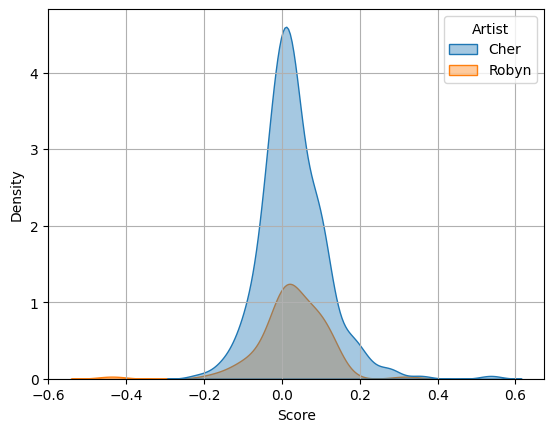

In [21]:
sns.kdeplot(data = lyrics_df, x="Score", hue="Artist", fill=True, alpha=0.4)
plt.grid()
plt.show()

#### Here is an additional plot zoomed in closer to the center to see where there may be a difference in the majority of sentiment recordings for each artist.

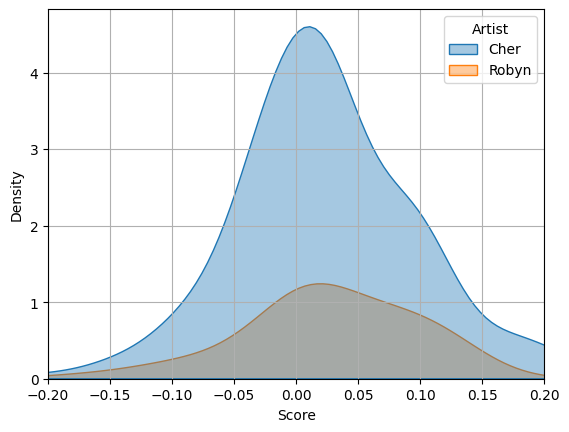

In [22]:
sns.kdeplot(data = lyrics_df, x="Score", hue="Artist", fill=True, alpha=0.4)
plt.xlim(-0.2, 0.2)
plt.grid()
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [23]:
rows_to_drop = twitter_df['description'].str.len() == 0
twitter_df = twitter_df.drop(twitter_df[rows_to_drop].index)

twitter_df['Score'] = twitter_df['description'].apply(sent_analysis)
twitter_df.head(10)

,description,artist,Score
0,[nan],Cher,0.000000
1,"[𝙿𝚛𝚘𝚞𝚍, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚘𝚏, 𝚖𝚎𝚜𝚜𝚢, 𝚋𝚞𝚗𝚜, 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜]",Cher,0.000000
2,"[163㎝／愛かっぷ💜26歳🍒, 工〇好きな女の子💓, フォローしてくれたらdmします🧡]",Cher,0.000000
3,[csu],Cher,0.000000
4,"[writer, washinformer, spelmancollege, alumna,...",Cher,0.000000
6,"[i’m, unemployed, live, parents, moops]",Cher,-0.200000
7,"[zoowee, mama]",Cher,0.000000
9,"[let, healing, begin, let, us, learn, past, 🇨🇦...",Cher,0.000000
10,"[thou, wilt, 🖤✨]",Cher,-0.333333
12,"[curious, canadian, contemplator, sheher, sexa...",Cher,0.000000


In [24]:
twitter_df = twitter_df.sort_values(by='Score')
twitter_df

,description,artist,Score
2400021,[spooky],Cher,-1.0
115214,[fuck],Robyn,-1.0
310331,[bum],Cher,-1.0
3654023,[sick],Cher,-1.0
755841,[fuck],Cher,-1.0
...,...,...,...
3277972,"[love, love]",Cher,1.0
914567,[sexy],Cher,1.0
520445,[best],Cher,1.0
2749637,[boom],Cher,1.0


### Questions

__Q:__ What is the average sentiment of your two artists? 

In [25]:
cher_twitter = twitter_df.loc[twitter_df['artist'].isin(['Cher'])]
robyn_twitter = twitter_df.loc[twitter_df['artist'].isin(['Robyn'])]

print("Cher's followers' average sentiment score is:", cher_twitter['Score'].mean().round(4))
print("Robyns's followers' average sentiment score is:", robyn_twitter['Score'].mean().round(4))

Cher's followers' average sentiment score is: 0.0445
Robyns's followers' average sentiment score is: 0.0279


__A:__ The average sentiment for Cher's Twitter followers is 0.0445 while the average sentiment for Robyn's followers is only 0.0279. This means that Cher's average sentiment is almost double that of Robyn's followers.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

In [26]:
## this will return all the descriptions into one string
def flatten(l):
    return [item for sublist in l for item in sublist]

cher_tokens = flatten(cher_twitter['description'])
robyn_tokens = flatten(robyn_twitter['description'])

In [27]:
## returns only the emojis in the string
def find_emoji(text):
    return ''.join(emojis for emojis in text if emojis in emoji.UNICODE_EMOJI['en'])

cher_emojis = find_emoji(cher_tokens)
robyn_emojis = find_emoji(robyn_tokens)

In [28]:
## creates dictionary of emoji frequency
def count_emojis(text):
    emoji_dict = {}
    for character in text:
        if character in emoji.UNICODE_EMOJI['en']:
            if character in emoji_dict:
                emoji_dict[character] += 1
            else:
                emoji_dict[character] = 1
    return emoji_dict

cher_emoji_dict = count_emojis(cher_emojis)
robyn_emoji_dict = count_emojis(robyn_emojis)

In [29]:
print(find_emoji(positive_words))
print(find_emoji(negative_words))

The print statements above show that there are no emoji's in the positive or negative words lists. This means that we must delineate positive vs negative emojis in a different manner.

In [30]:
## save dictionaries as dataframes for easier sorting
cher_emoji_df = pd.DataFrame.from_dict(cher_emoji_dict, orient='index')
robyn_emoji_df = pd.DataFrame.from_dict(robyn_emoji_dict, orient='index')

cher_emoji_df = cher_emoji_df.sort_values(by=cher_emoji_df.columns[0], ascending = False)
robyn_emoji_df = robyn_emoji_df.sort_values(by=robyn_emoji_df.columns[0], ascending = False)

In [31]:
print("Cher's Top 10 Emojis")
print(cher_emoji_df.head(10))

print("Robyn's Top 10 Emojis")
print(robyn_emoji_df.head(10))

Cher's Top 10 Emojis
       0
❤  23932
🌈  18828
🏳  14455
♥  11508
✨   7978
🏻   6094
✌   4529
🏼   4279
♀   4050
💙   3595
Robyn's Top 10 Emojis
      0
🌈  2208
🏳  1765
❤  1617
♥  1211
✨   719
🏻   569
🏼   413
✌   393
♀   324
🎶   267


__A:__ Because our lexicon lists for positive and negative words did not contain emojis, I decided to print the top 10 frequenct emojis for followers of both Cher and Robyn to compare by looking what are the most frequent positive and negative emojis.

For Cher's followers, the most common negative emoji appears to be the black hear whereas the most common positive emoji is the rainbow flag.

For Robyn's followers, the most common negative emoji appears to be the small black heart again, whereas the most positive emoji is again the rainbow flag. The difference here though with Robyn's followers as compared to Cher's followers is that the most common positive emoji is more frequent than the most common negative emoji.